In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
datadir = '/ix/djishnu/shared/djishnu_kor11/training_data'

adata = sc.read_h5ad(f'{datadir}/survey_kidney.h5ad')
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster_cat'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'normalized_count', 'npc-l1p', 'raw_count'
    obsp

In [4]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

2024-12-19 11:01:11.120158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 11:01:11.145377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 11:01:12.223289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


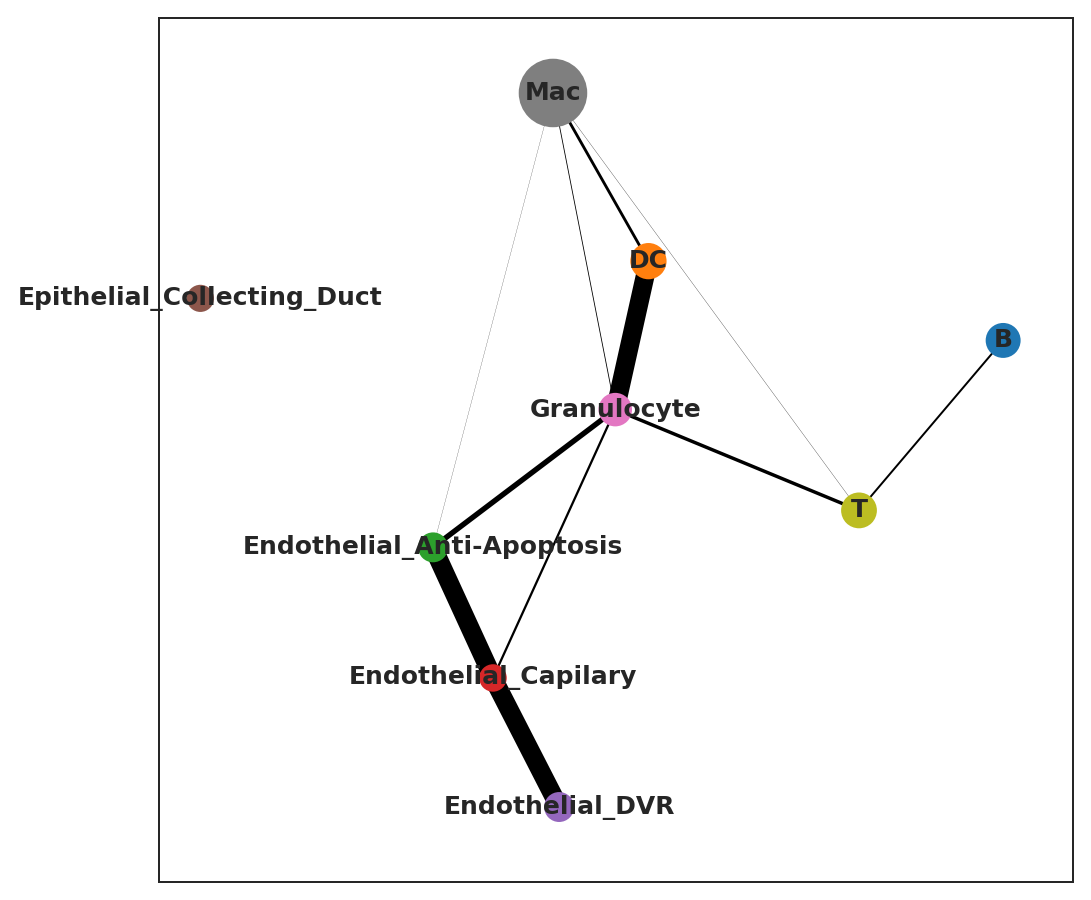

CPU times: user 6.11 s, sys: 309 ms, total: 6.42 s
Wall time: 7.81 s


In [5]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='ct2')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

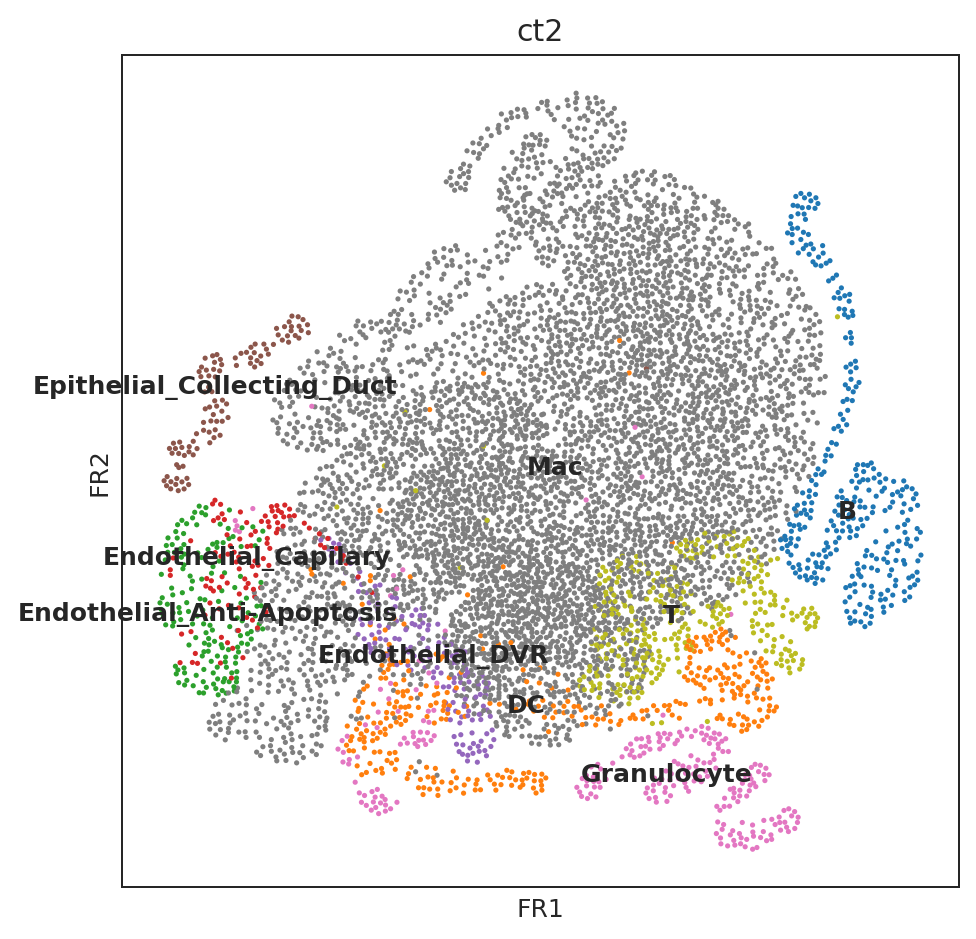

In [6]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='ct2', legend_loc='on data')

In [7]:
adata.X.min(), adata.X.max()

(0.0, 6.84927)

In [8]:
oracle = co.Oracle()

adata.layers['raw_count'] = adata.X.copy() # Just saving original data

oracle.import_anndata_as_normalized_count(
    adata=adata,
    cluster_column_name="ct2",
    embedding_name="X_draw_graph_fr"
)

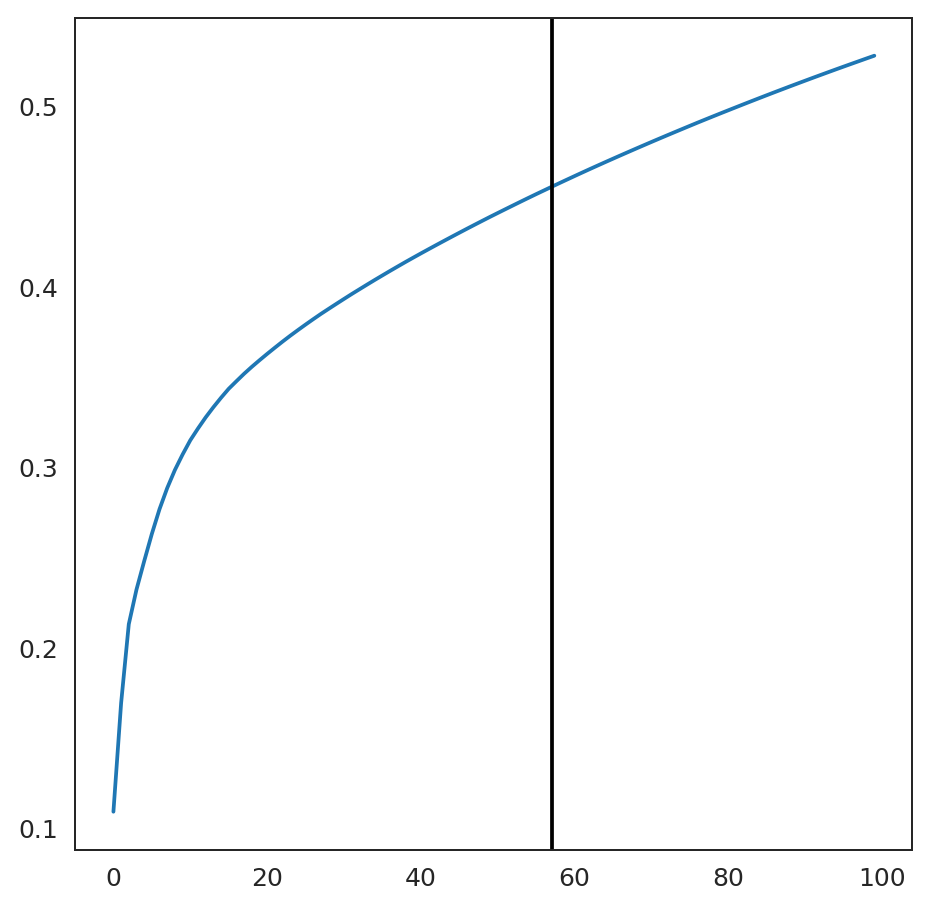

57


In [9]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [10]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6959
Auto-selected k is :173


In [11]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [12]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [13]:
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster_cat'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'diffmap_evals', 'paga', 'ct2_sizes', 'ct2_colors', 'draw_graph'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial', 'X_diffmap', 'X_dra

In [14]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="ct2", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for B...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for DC...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Anti-Apoptosis...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Capilary...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_DVR...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Epithelial_Collecting_Duct...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Granulocyte...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Mac...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for T...


  0%|          | 0/2295 [00:00<?, ?it/s]

CPU times: user 13min 25s, sys: 3.15 s, total: 13min 28s
Wall time: 15min 3s


In [15]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
import pickle

with open(f'../../data/kidney/celloracle_links.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

with open('/ix/djishnu/shared/djishnu_kor11/training_data/kidney_celloracle.pkl', 'wb') as f:
    pickle.dump(oracle, f)